In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np



In [2]:
import utils.load_grid as lg
from utils.load_cmaps import *

In [3]:
pgrid_dir = "data/shared/jgr_2"
cases = lg.get_cases(pgrid_dir)

In [4]:
# Collect netcdf files
stts = lg.get_statuses(pgrid_dir)

# Configuration variables
cvars = lg.load_cvars(cases)

# Helpfiles
helps, hvars = lg.load_helpfiles(cases)

print("Done")

Helpfiles: 100%|██████████| 266/266 [00:06<00:00, 39.34it/s]


Done


In [5]:
def _pie(ax, x, y, s, ratios, colors, tris=50):

    markers = []
    previous = 0
    # calculate the points of the pie pieces
    for color, ratio in zip(colors, ratios):
        this = 2 * np.pi * ratio + previous
        x_tmp  = [0] + np.cos(np.linspace(previous, this, tris)).tolist() + [0]
        y_tmp  = [0] + np.sin(np.linspace(previous, this, tris)).tolist() + [0]
        xy = np.column_stack([x_tmp, y_tmp])
        previous = this
        markers.append({'marker':xy, 's':(np.abs(xy).max())**2*s, 'facecolor':color})

    # scatter each of the pie pieces to create pies
    for marker in markers:
        ax.scatter([x], [y], **marker)

    return ax

In [6]:
def make_pies(x,x_lbl, y,y_lbl, control,plot_casenums=False,plot_controls=False, logx=False, logy=False):
    # Make plot
    x_plt = np.array([], dtype=float) # x variable
    y_plt = np.array([], dtype=float) # y variable 
    c_plt = np.array([], dtype=int)   # case number
    g_plt = np.array([], dtype=bool)  # case finished with success? (good)
    g_plt = np.array([], dtype=bool)  # case finished with failure? (bad)
    for i in range(len(x)):
        skip_this = False
        for k in control.keys():
            if k in cvars.keys():
                if not np.isclose(cvars[k][i],control[k]):
                    skip_this = True
                    break
        if skip_this:
            continue 
        x_plt = np.append(x_plt, x[i])
        y_plt = np.append(y_plt, y[i])
        c_plt = np.append(c_plt, i)
        g_plt = np.append(g_plt, bool( 10 <= stts[i] <= 19))
    if len(x_plt) == 0:
        print("WARNING: No data left after applying control variables!")
        return

    b_plt = np.invert(g_plt)
        
    fig,ax = plt.subplots(1,1, figsize=(7,5))

    present = np.full(len(lg.volatile_species), False)
    for j,v in enumerate(lg.volatile_species):
        for i in range(len(x_plt)):
            r = lg.access_hvars(hvars,v+"_mr",-1)[c_plt[i]]
            if r > 1.0e-30:
                present[j] = True
    
    # Make the pies
    for i in range(len(x_plt)):
        ratios = []
        colors = []
        for j,v in enumerate(lg.volatile_species):
            if not present[j]:
                continue
            ratios.append(lg.access_hvars(hvars,v+"_mr",-1)[c_plt[i]])
            colors.append(lg.volatile_colors[v])
        # s = (endp[i]*1.0e-5) / 1e3 * 1200.0
        s = 1000
        ax = _pie(ax, x_plt[i], y_plt[i], s, ratios, colors)

    # Legend
    patches = []
    for j,v in enumerate(lg.volatile_species):
        if present[j]:
            patches.append(mpatches.Patch(color=lg.volatile_colors[v], label=v))
    ax.legend(handles=patches,loc='center left', bbox_to_anchor=(1, 0.5))

    if plot_casenums:
        for i in range(len(x_plt)):
            ax.text(x_plt[i],y_plt[i],c_plt[i],fontsize=7, color='magenta', horizontalalignment='center', verticalalignment='center')

    if plot_controls:
        control_str = "Control variables:\n"
        for k in control.keys():
            control_str += "  %s=%g\n" % (k,control[k])
        control_str = control_str[:-1]
        axt = ax.text(0.05, 0.95, control_str, 
                horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, fontsize=10)
        axt.set_bbox(dict(facecolor='white', alpha=0.5, linewidth=0))

    ax.set_xlabel(x_lbl)
    ax.set_ylabel(y_lbl)
    if logy:
        ax.set_yscale("log")
    if logx:
        ax.set_xscale("log")

    plt.show()

IndexError: index -1 is out of bounds for axis 0 with size 0

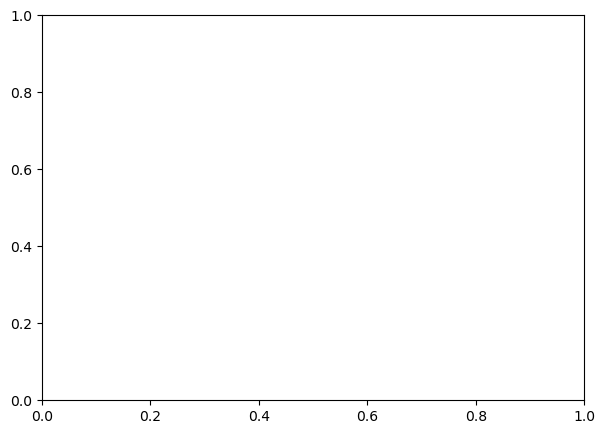

In [7]:
# Variables
x = cvars["mean_distance"];  x_lbl = "Orbital separation [AU]"
y = cvars["CH_ratio"];      y_lbl = "C/H ratio"
control = {"fO2_shift_IW":0.0}

plot_controls = True
plot_casenums = False

make_pies(x,x_lbl, y,y_lbl, control, logx=True, logy=True,
          plot_casenums=plot_casenums, plot_controls=plot_controls)
